In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import math
import PIL.Image as Img
from unet import UNet

/home/ilya/Desktop/pet/diffusino/unet.py:10: SyntaxWarning: invalid escape sequence '\c'
  """


In [7]:
def noisify_batch(x0, timestamps, beta):
    # x0: (B, C, H, W)
    # timestamps: (B,)
    alpha_t = torch.exp(math.log(1-beta) * timestamps)[:, None, None, None]  # (B, 1, 1, 1)
    eps = torch.randn_like(x0)
    x_t = torch.sqrt(alpha_t) * x0 + torch.sqrt(1 - alpha_t) * eps
    return x_t


def noisify_image_one_step(x_t, beta):
    # for visualizations
    eps = torch.randn_like(x_t)
    return math.sqrt(1 - beta) * x_t + math.sqrt(beta) * eps

In [ ]:
#class ZTransform:
#   # variance preserving diffusion
#   def __call__(self, tensor):
#       mean = tensor.mean()
#       std = tensor.std()
#       return (tensor - mean) / (std + 1.0e-7)

class MNIST_Normalized(torch.utils.data.Dataset):
    def __init__(self):
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(32),
            transforms.Normalize(mean=(0.1307,), std=(0.3081,))  # mnist mean and std
        ])
        self.mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=self.transforms)
    
    def __getitem__(self, idx):
        return self.mnist[idx][0]
    
    def __len__(self):
        return len(self.mnist)

In [162]:
mnist = MNIST_Normalized()

In [164]:
T = 1000
beta = 0.01

n_epochs = 40
log_steps = 50
bs=1024
lr=1.0e-4
wd=1.0e-4

In [165]:
model = UNet(
    image_channels=1,
    n_channels=8,
    n_blocks=1,
    is_attn=(False, False, True, True)
)
model.train()
model.cuda()

dataloader = torch.utils.data.DataLoader(
    mnist,
    batch_size=bs,
    shuffle=True,
    num_workers=16
)

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=lr,
    weight_decay=wd
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=n_epochs*len(mnist) / bs,
    eta_min=lr/10    
)
scaler = torch.amp.GradScaler()
loss_history = []
avg_loss = 0
step = 0
for epoch_idx in range(n_epochs):
    for i, batch in enumerate(dataloader):
        optimizer.zero_grad()
        batch = batch.cuda()
        timestamps = torch.randint(0, T+1, size=(batch.shape[0],), device='cuda')
        x_t = noisify_batch(batch, timestamps, beta)
        with torch.autocast(device_type="cuda"):
            pred_x0 = model(x_t, timestamps)
            loss = F.mse_loss(pred_x0, batch)
            avg_loss += loss.item()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        if (step + 1) % log_steps == 0:
            avg_loss /= log_steps
            print(f'Epoch {epoch_idx} Step: {step} Loss: {avg_loss:.3f} LR: {optimizer.param_groups[0]['lr']}')
            loss_history.append(avg_loss)
        step += 1

Epoch 0 Step: 49 Loss: 0.732 LR: 9.989897307520811e-05
Epoch 1 Step: 99 Loss: 0.582 LR: 9.959634592036718e-05
Epoch 2 Step: 149 Loss: 0.541 LR: 9.909347735729106e-05
Epoch 3 Step: 199 Loss: 0.517 LR: 9.83926253088466e-05
Epoch 4 Step: 249 Loss: 0.500 LR: 9.749693666068652e-05
Epoch 5 Step: 299 Loss: 0.490 LR: 9.641043313146401e-05
Epoch 5 Step: 349 Loss: 0.482 LR: 9.513799321497159e-05
Epoch 6 Step: 399 Loss: 0.476 LR: 9.368533027528693e-05
Epoch 7 Step: 449 Loss: 0.472 LR: 9.205896689327902e-05
Epoch 8 Step: 499 Loss: 0.466 LR: 9.026620557966255e-05
Epoch 9 Step: 549 Loss: 0.460 LR: 8.831509598609978e-05
Epoch 10 Step: 599 Loss: 0.458 LR: 8.621439876157596e-05
Epoch 11 Step: 649 Loss: 0.455 LR: 8.397354621633618e-05
Epoch 11 Step: 699 Loss: 0.453 LR: 8.160259997000516e-05
Epoch 12 Step: 749 Loss: 0.451 LR: 7.911220577405463e-05
Epoch 13 Step: 799 Loss: 0.449 LR: 7.651354571146841e-05
Epoch 14 Step: 849 Loss: 0.446 LR: 7.38182879882334e-05
Epoch 15 Step: 899 Loss: 0.444 LR: 7.103853454

In [166]:
model.eval()

UNet(
  (image_proj): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_emb): TimeEmbedding(
    (lin1): Linear(in_features=8, out_features=32, bias=True)
    (act): Swish()
    (lin2): Linear(in_features=32, out_features=32, bias=True)
  )
  (down): ModuleList(
    (0): DownBlock(
      (res): ResidualBlock(
        (norm1): GroupNorm(8, 8, eps=1e-05, affine=True)
        (act1): Swish()
        (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): GroupNorm(8, 8, eps=1e-05, affine=True)
        (act2): Swish()
        (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (shortcut): Identity()
        (time_emb): Linear(in_features=32, out_features=8, bias=True)
        (time_act): Swish()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (attn): Identity()
    )
    (1): Downsample(
      (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (2): DownBlock(
 

In [ ]:
def ddpm_posterior_sample(x_t, x0_hat, beta: float, t: int):
    """
    One step   x_{t} → x_{t-1}   assuming a *constant* β schedule
    and a UNet that predicts x̂₀.
    """
    # cumulative alphas
    alpha_bar_t      = (1.0 - beta) ** t
    alpha_bar_t_prev = (1.0 - beta) ** (t - 1)

    # cast to same device / dtype
    device, dtype = x_t.device, x_t.dtype
    a_prev  = torch.tensor(alpha_bar_t_prev, device=device, dtype=dtype)
    beta_t  = torch.tensor(beta,               device=device, dtype=dtype)
    onemb   = torch.tensor(1.0 - beta,         device=device, dtype=dtype)

    # posterior mean μ̃_t
    coef_x0 = torch.sqrt(a_prev) * beta_t / (1 - alpha_bar_t)
    coef_xt = torch.sqrt(onemb) * (1 - a_prev) / (1 - alpha_bar_t)
    mu = coef_x0 * x0_hat + coef_xt * x_t

    # posterior variance β̃_t
    beta_tilde = (1 - a_prev) / (1 - alpha_bar_t) * beta_t   # scalar on the right device

    if t > 1:                         # t = 1 ⇒ x_{0}, no more noise
        eps   = torch.randn_like(x_t)
        x_tm1 = mu + torch.sqrt(beta_tilde) * eps
    else:
        x_tm1 = mu

    return x_tm1


def generate_image(model, T=1000, beta=0.02):
    x = torch.randn(1, 1, 32, 32, device='cuda')
    history = []

    for t in range(T, 0, -1):
        if t < 100 and t % 10 == 0:
            history.append(x[0, 0].cpu())

        with torch.no_grad(), torch.autocast('cuda'):
            timestamps = torch.tensor([t], dtype=torch.float32, device='cuda')
            x0_hat = model(x, timestamps)

        x = ddpm_posterior_sample(x, x0_hat, beta, t)

    return x[0, 0].cpu(), history


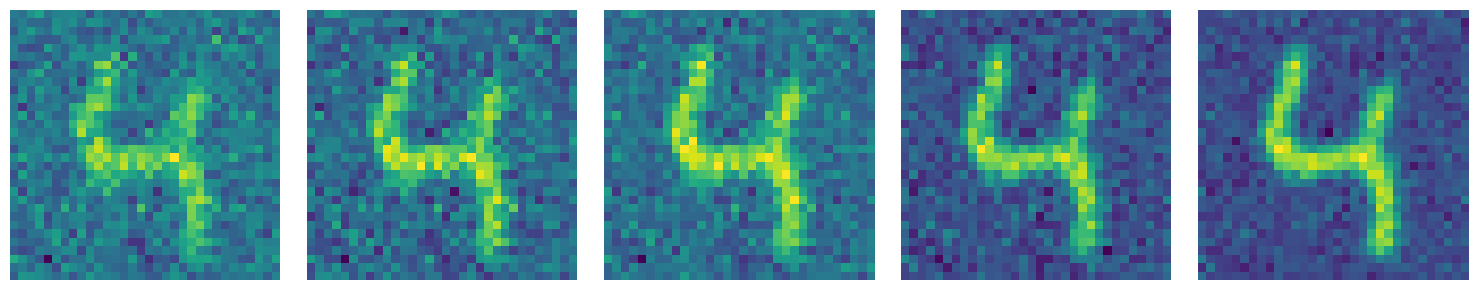

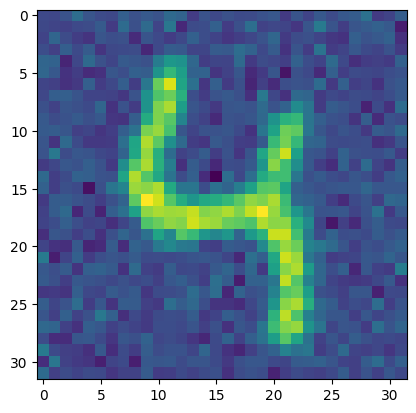

In [170]:
img, history = generate_image(model, T=T, beta=beta)
last_five = history[-5:]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for ax, img in zip(axes, last_five):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()
plt.imshow(img)
plt.show()
